In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn as sk
import plotly.express as px

import sys 

%matplotlib inline 
import warnings
warnings.simplefilter("ignore")
from pprint import pprint
import joblib
import imblearn

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.preprocessing import scale
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import reciprocal, uniform

df = pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Initial Cleaning 

- Identifying and removing null values
- Identifying and removal of duplicate values
- Removal of non-necessary columns 

In [20]:
df.isin(['?']).sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

#Too much data is missing from weight, payer code and medical history so these features are removed from consideration

#The rows of data missing variables for race, and all 3 diagnosis columns are removed

In [21]:
#Drop duplicate records of patients
new_df = df.drop_duplicates(subset="patient_nbr")

In [22]:
#Remove columns with many missing rows and irrelevant info 
Cleaned_df1 = new_df.drop(['patient_nbr','encounter_id', 'weight', 'payer_code', 'medical_specialty'], axis = 1) 
Cleaned_df2 = Cleaned_df1.loc[(Cleaned_df1['race'] != '?')]
Cleaned_df3 = Cleaned_df2.loc[(Cleaned_df2['diag_1'] != '?')]
Cleaned_df4 = Cleaned_df3.loc[(Cleaned_df3['diag_2'] != '?')]
Cleaned_df = Cleaned_df4.loc[(Cleaned_df4['diag_3'] != '?')]
Cleaned_df.isin(['?']).sum()
print(len(Cleaned_df))

68358


In [23]:
Cleaned_df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000,68358.000000
mean,2.103587,3.636283,5.682012,4.318178,43.139618,1.445156,15.813160,0.286141,0.106001,0.181413,7.349045
std,1.514801,5.306901,4.173131,2.958282,20.005393,1.763509,8.290263,1.084633,0.516162,0.609036,1.884519
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


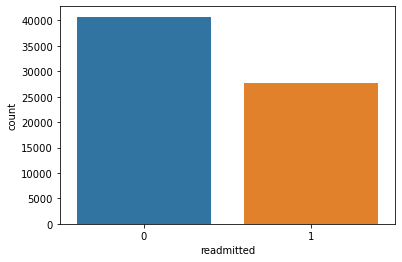

In [24]:
All_readmissions = Cleaned_df.copy()
All_readmissions.describe()

#Combine readmission target classes
All_readmissions['readmitted'] = All_readmissions['readmitted'].map({'NO':0, '>30': 1, '<30':1})

plt.figure()
sns.countplot(x='readmitted', data = All_readmissions)
plt.show()

# Exploratory Data Analysis

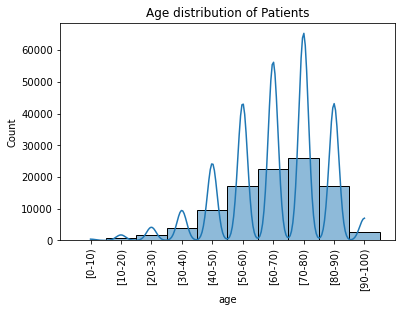

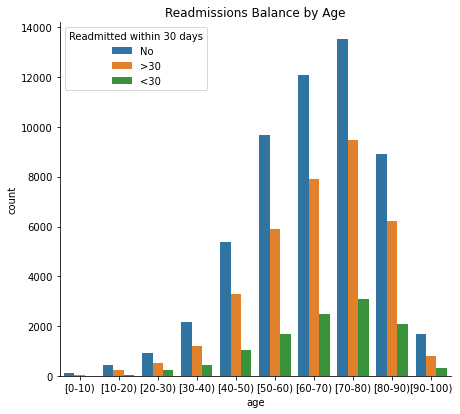

In [25]:
#Relation between age and readmission,

plt.figure()
plt.title('Age distribution of Patients')
sns.histplot(df['age'] , bins = 10,kde = True) # skewed maybe needs to be normalized later
plt.xticks(rotation=90)
plt.show()


b = df.age.unique()
b.sort()
b_sort = np.array(b).tolist()


ageplt = sns.countplot(x = 'age', hue = 'readmitted', data = df, order = b_sort) 

sns.despine()
ageplt.figure.set_size_inches(7, 6.5)
ageplt.legend(title = 'Readmitted within 30 days', labels = ('No', '>30', '<30'))
ageplt.axes.set_title('Readmissions Balance by Age')
plt.show()

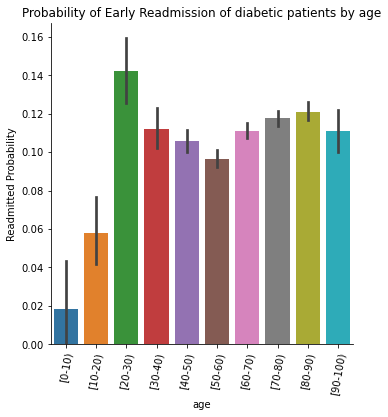

In [26]:
df = pd.read_csv('diabetic_data.csv')
diabetic_df = df
age_id = {'[0-10)' : 5, '[10-20)': 15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65,'[70-80)':75, '[80-90)':85, '[90-100)':95}
#diabetic_df['age'] = diabetic_df.age.replace(age_id)
diabetic_df['readmitted'] = diabetic_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

g = sns.catplot(x = "age", y = "readmitted", data = diabetic_df, kind = "bar", height = 5)
g.set_ylabels("Readmitted Probability")
plt.title('Probability of Early Readmission of diabetic patients by age')
plt.xticks(rotation = 80)
plt.show()

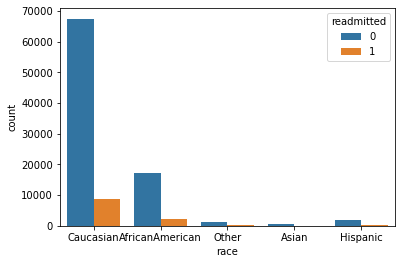

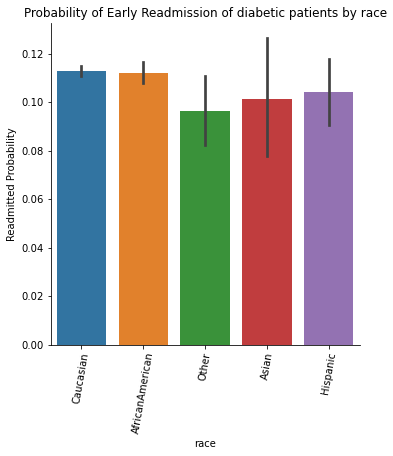

Race distribution of Patients
Caucasian          76.486788
AfricanAmerican    19.307891
Hispanic            2.047380
Other               1.513674
Asian               0.644266
Name: race, dtype: float64


In [27]:
df = pd.read_csv('diabetic_data.csv')
diabetic_df = df

diabetic_df['readmitted'] = diabetic_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

df1 = diabetic_df.loc[(diabetic_df['race'] != '?')]

plt.figure()
sns.countplot(x="race",hue = 'readmitted', data=df1)
plt.show()

g = sns.catplot(x = "race", y = "readmitted", data = df1, kind = "bar", height = 5)
g.set_ylabels("Readmitted Probability")
plt.title('Probability of Early Readmission of diabetic patients by race')
plt.xticks(rotation = 80)
plt.show()

print("Race distribution of Patients")
print(df1.race.value_counts(normalize = True)*100)

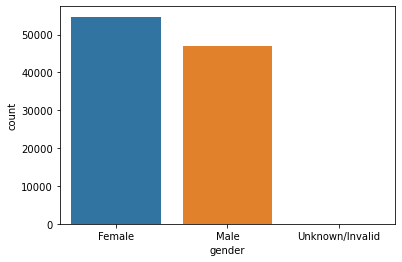

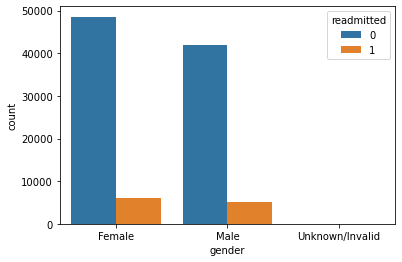

Gender distribution of Patients
Female             53.848009
Male               46.150985
Unknown/Invalid     0.001005
Name: gender, dtype: float64


In [28]:
df = pd.read_csv('diabetic_data.csv')
diabetic_df = df

diabetic_df['readmitted'] = diabetic_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

df1 = diabetic_df.loc[(diabetic_df['race'] != '?')]

plt.figure()
sns.countplot(x="gender", data=df)
plt.show()

plt.figure()
sns.countplot(x="gender", hue = 'readmitted', data=df)
plt.show()

print("Gender distribution of Patients")
print(df1.gender.value_counts(normalize = True)*100)

Text(0, 0.5, 'Count')

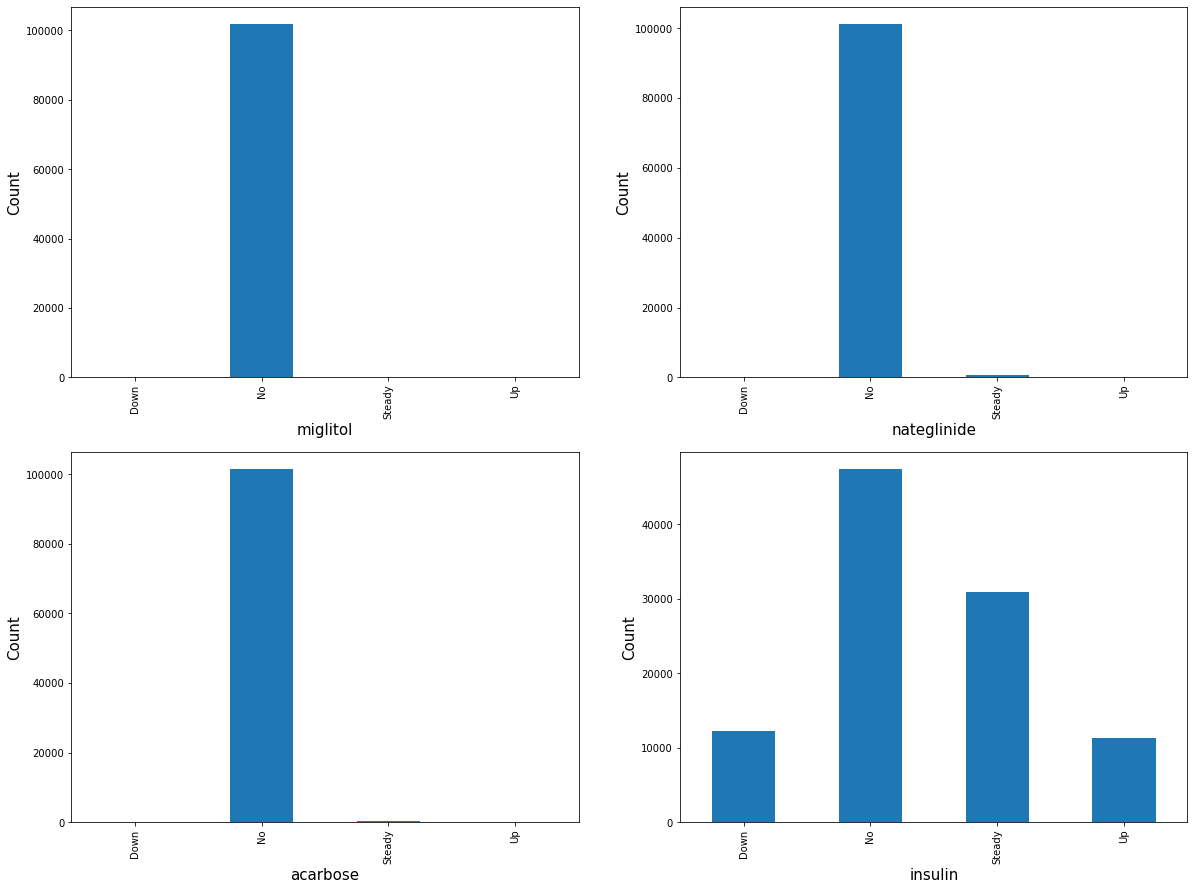

In [29]:
list(df.columns.values)
medications = ['metformin','repaglinide', 'nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

# compare diabetes medications 'miglitol', 'nateglinide' and 'acarbose' with 'insulin', as an example
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1 = df.groupby('miglitol').size().plot(kind='bar')
plt.xlabel('miglitol', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax2 = fig.add_subplot(222)
ax2 = df.groupby('nateglinide').size().plot(kind='bar')
plt.xlabel('nateglinide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax3 = fig.add_subplot(223)
ax3 = df.groupby('acarbose').size().plot(kind='bar')
plt.xlabel('acarbose', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax4 = fig.add_subplot(224)
ax4 = df.groupby('insulin').size().plot(kind='bar')
plt.xlabel('insulin', fontsize=15)
plt.ylabel('Count', fontsize=15)


Text(0, 0.5, 'Count')

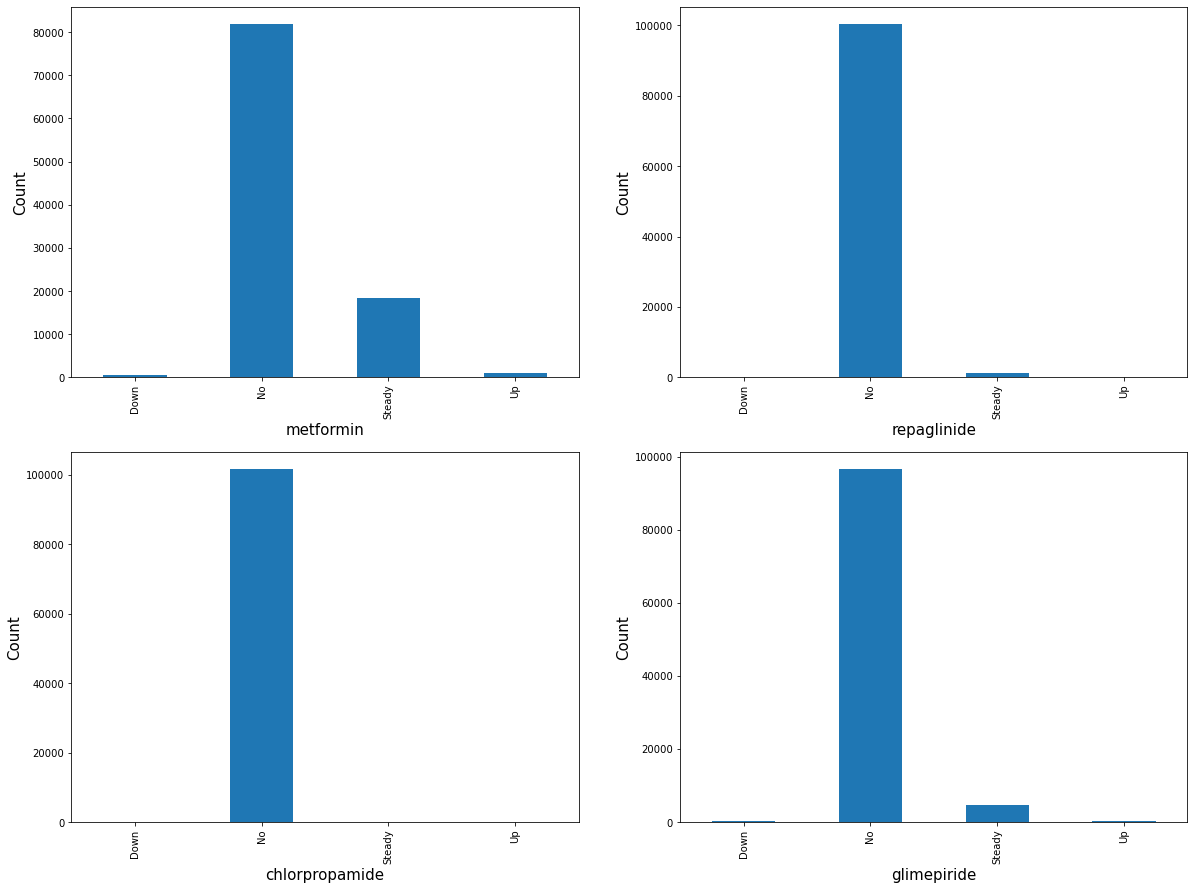

In [30]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1 = df.groupby('metformin').size().plot(kind='bar')
plt.xlabel('metformin', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax2 = fig.add_subplot(222)
ax2 = df.groupby('repaglinide').size().plot(kind='bar')
plt.xlabel('repaglinide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax3 = fig.add_subplot(223)
ax3 = df.groupby('chlorpropamide').size().plot(kind='bar')
plt.xlabel('chlorpropamide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax4 = fig.add_subplot(224)
ax4 = df.groupby('glimepiride').size().plot(kind='bar')
plt.xlabel('glimepiride', fontsize=15)
plt.ylabel('Count', fontsize=15)

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

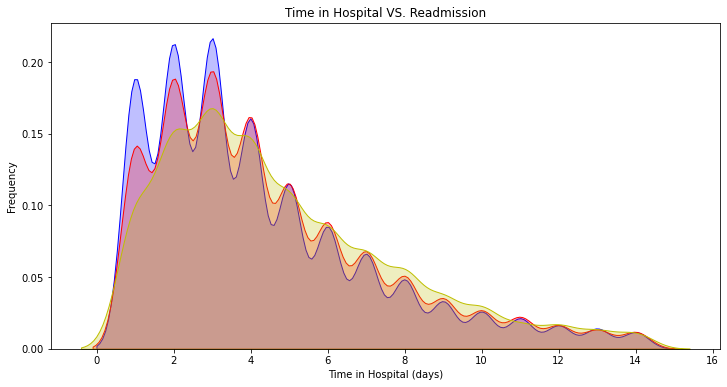

In [31]:
df = pd.read_csv('diabetic_data.csv')
fig = plt.figure(figsize=(12,6))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 'NO'),'time_in_hospital'] , color='b',shade=True,label='No readmittion')
ax=sns.kdeplot(df.loc[(df['readmitted'] == '>30'),'time_in_hospital'] , color='r',shade=True, label='Readmittion in >30 days')
ax=sns.kdeplot(df.loc[(df['readmitted'] == '<30'),'time_in_hospital'] , color='y',shade=True, label='Readmitted in <30 days')
ax.set(xlabel='Time in Hospital (days)', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

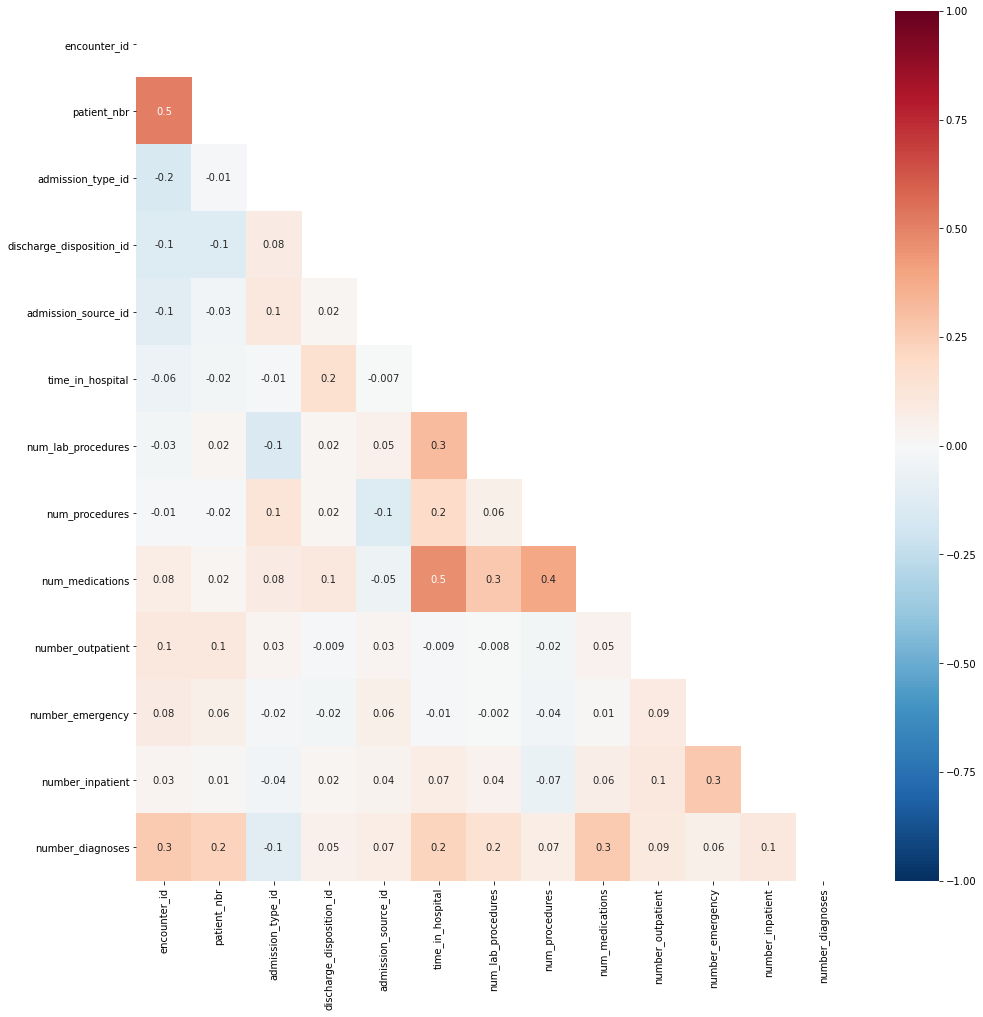

In [32]:
matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt='.1g', vmin=-1, vmax=1, center= 0, mask=matrix, cmap='RdBu_r')
plt.show()

Text(0.5, 1.0, 'Number of Medications VS. Readmission')

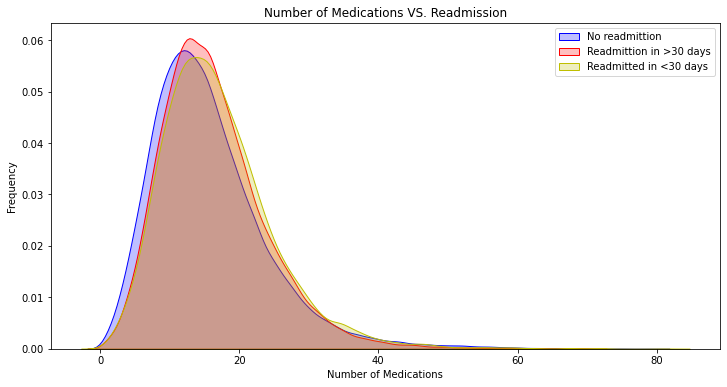

In [33]:
df = pd.read_csv('diabetic_data.csv')
fig = plt.figure(figsize=(12,6))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 'NO'),'num_medications'] , color='b',shade=True,label='No readmittion')
ax=sns.kdeplot(df.loc[(df['readmitted'] == '>30'),'num_medications'] , color='r',shade=True, label='Readmittion in >30 days')
ax=sns.kdeplot(df.loc[(df['readmitted'] == '<30'),'num_medications'] , color='y',shade=True, label='Readmitted in <30 days')
ax.set(xlabel='Number of Medications', ylabel='Frequency')
plt.legend()
plt.title('Number of Medications VS. Readmission')

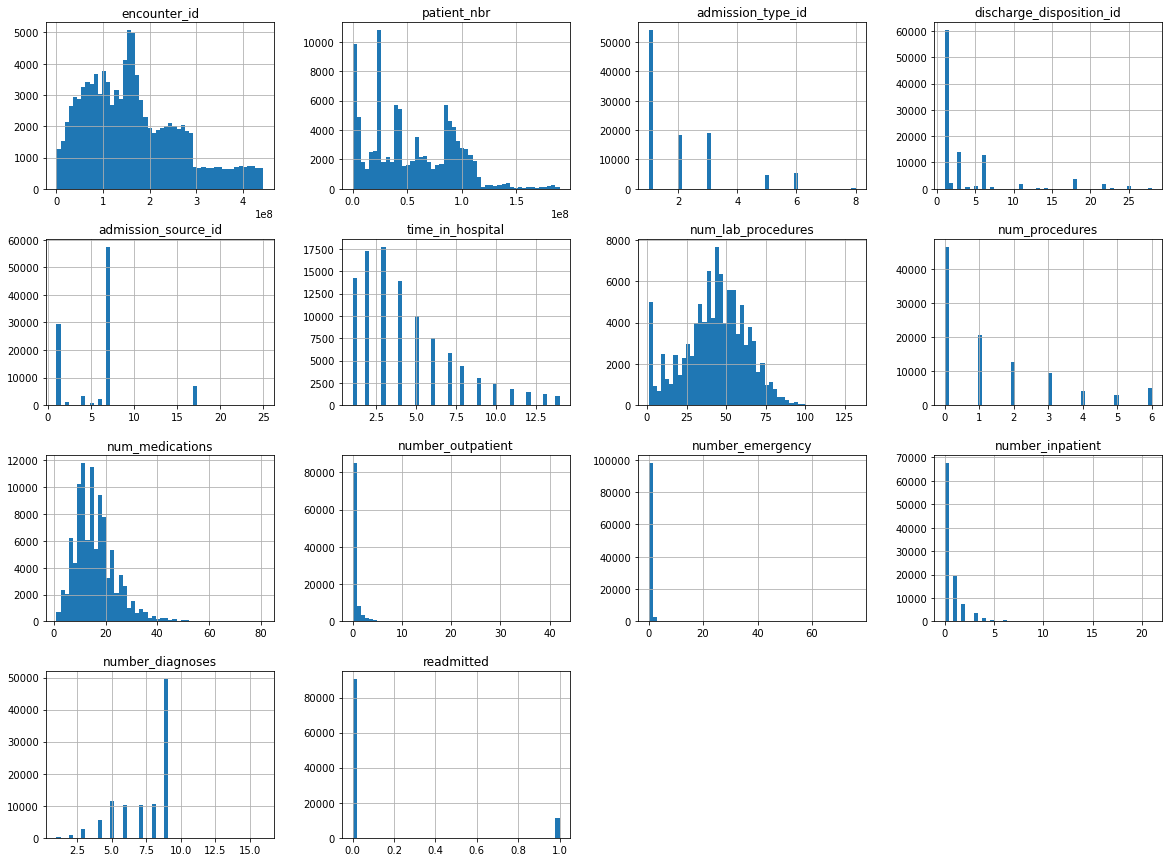

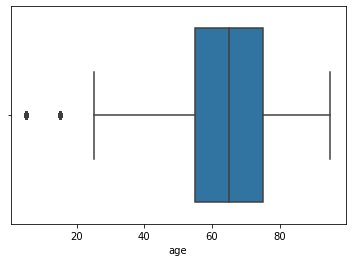

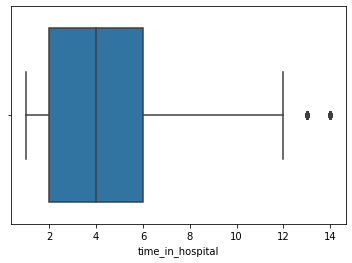

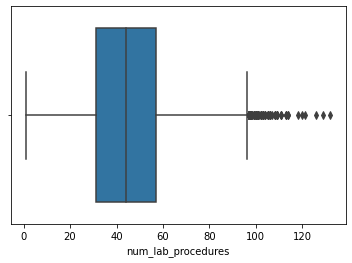

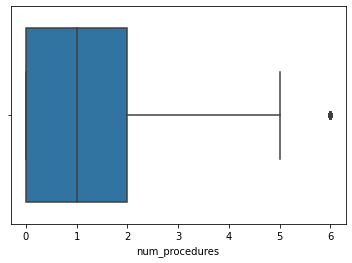

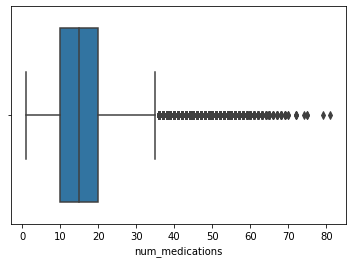

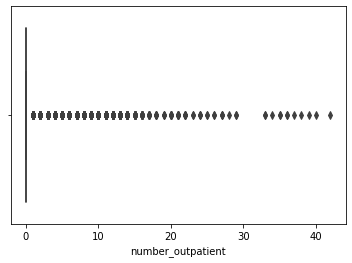

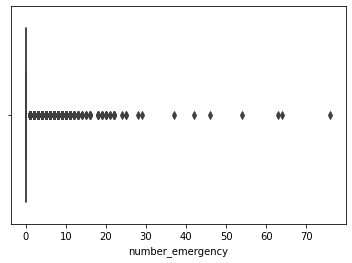

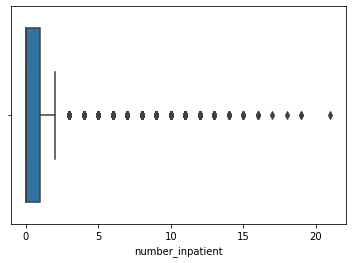

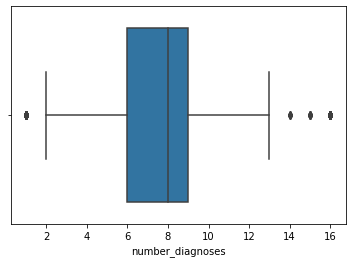

KeyError: 'preceding_year_visits'

In [18]:
#Plotting the numerical variables in our dataset,

%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

df1 = pd.read_csv('diabetic_data.csv')

age_id = {'[0-10)' : 5, '[10-20)': 15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65,'[70-80)':75, '[80-90)':85, '[90-100)':95}
df1['age'] = df1.age.replace(age_id)


num_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses','preceding_year_visits', 'number_diab_meds', 'number_changes']
for i in num_cols:
    sns.boxplot(df1[i])
    plt.show()

# Cleaned model Classifying All readmissions

In [34]:
X_encoded = pd.get_dummies(All_readmissions, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()
X_train, X_test,y_train,y_test = train_test_split(x,y,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predict_log = logmodel.predict(X_test)
auc_log = roc_auc_score(y_test, predict_log)
print(classification_report(y_test,predict_log))
print(confusion_matrix(y_test,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
predict_knn = clf.predict(X_test)
auc_knn = roc_auc_score(y_test, predict_knn)
print(classification_report(y_test,predict_knn))
print(confusion_matrix(y_test,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
predict_tree = tree_model.predict(X_test)
auc_DT = roc_auc_score(y_test, predict_tree)
print(classification_report(y_test,predict_tree))
print(confusion_matrix(y_test,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)
auc_rf = roc_auc_score(y_test, predict_rf)
print(classification_report(y_test,predict_rf))
print(confusion_matrix(y_test,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train, y_train)
predict_xgb = xgb.predict(X_test)
auc_xgb = roc_auc_score(y_test, predict_xgb)
print(classification_report(y_test,predict_xgb))
print(confusion_matrix(y_test,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.64      0.86      0.73     10155
           1       0.59      0.30      0.40      6935

    accuracy                           0.63     17090
   macro avg       0.62      0.58      0.57     17090
weighted avg       0.62      0.63      0.60     17090

[[8697 1458]
 [4837 2098]]
KNN
              precision    recall  f1-score   support

           0       0.62      0.72      0.66     10155
           1       0.46      0.35      0.39      6935

    accuracy                           0.57     17090
   macro avg       0.54      0.53      0.53     17090
weighted avg       0.55      0.57      0.55     17090

[[7290 2865]
 [4525 2410]]
Decision Trees
              precision    recall  f1-score   support

           0       0.63      0.65      0.64     10155
           1       0.47      0.45      0.46      6935

    accuracy                           0.57     17090
   macro avg       0.55      0.55  

In [35]:
print('Simple classification model')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Simple classification model
--------------------------------------------------------
Accuracy score of the DT model: 0.5691632533645407
Precision score of the DT model: 0.46776137390780353
Recall score of the DT model: 0.44772891131939435
F1 score of the DT model: 0.45752597067707945
AUC score of the DT model: 0.55
--------------------------------------------------------
Accuracy score of the KNN model: 0.5675833820947923
Precision score of the KNN model: 0.45687203791469194
Recall score of the KNN model: 0.3475126171593367
F1 score of the KNN model: 0.3947583947583948
AUC score of the KNN model: 0.53
--------------------------------------------------------
Accuracy score of the LR model: 0.6316559391456993
Precision score of the LR model: 0.5899887514060742
Recall score of the LR model: 0.3025234318673396
F1 score of the LR model: 0.3999618720808312
AUC score of the LR model: 0.58
--------------------------------------------------------
------------------------------------------------

# Classification of Early Readmission

- Determine whether to include over 30 days in our no target class or to exclude it from our analysis 

In [36]:
#Keeping and Putting >30 data in the no class
Include_30_df = Cleaned_df.copy()
Include_30_df['readmitted'] = Include_30_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()
X_train, X_test,y_train,y_test = train_test_split(x,y,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predict_log = logmodel.predict(X_test)
auc_log = roc_auc_score(y_test, predict_log)
print(classification_report(y_test,predict_log))
print(confusion_matrix(y_test,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
predict_knn = clf.predict(X_test)
auc_knn = roc_auc_score(y_test, predict_knn)
print(classification_report(y_test,predict_knn))
print(confusion_matrix(y_test,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
predict_tree = tree_model.predict(X_test)
auc_DT = roc_auc_score(y_test, predict_tree)
print(classification_report(y_test,predict_tree))
print(confusion_matrix(y_test,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)
auc_rf = roc_auc_score(y_test, predict_rf)
print(classification_report(y_test,predict_rf))
print(confusion_matrix(y_test,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train, y_train)
predict_xgb = xgb.predict(X_test)
auc_xgb = roc_auc_score(y_test, predict_xgb)
print(classification_report(y_test,predict_xgb))
print(confusion_matrix(y_test,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15521
           1       0.47      0.01      0.01      1569

    accuracy                           0.91     17090
   macro avg       0.69      0.50      0.48     17090
weighted avg       0.87      0.91      0.87     17090

[[15511    10]
 [ 1560     9]]
KNN
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     15521
           1       0.12      0.01      0.02      1569

    accuracy                           0.90     17090
   macro avg       0.51      0.50      0.48     17090
weighted avg       0.84      0.90      0.86     17090

[[15412   109]
 [ 1554    15]]
Decision Trees
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     15521
           1       0.15      0.14      0.15      1569

    accuracy                           0.85     17090
   macro avg       0.53    

In [37]:
print('30 day Readmission Keeping and Putting >30 data in the no class')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

30 day Readmission Keeping and Putting >30 data in the no class
--------------------------------------------------------
Accuracy score of the DT model: 0.8504973668812171
Precision score of the DT model: 0.15427769985974754
Recall score of the DT model: 0.14021669853409816
F1 score of the DT model: 0.1469115191986644
AUC score of the DT model: 0.53
--------------------------------------------------------
Accuracy score of the KNN model: 0.9026916325336454
Precision score of the KNN model: 0.12096774193548387
Recall score of the KNN model: 0.009560229445506692
F1 score of the KNN model: 0.01772002362669817
AUC score of the KNN model: 0.50
--------------------------------------------------------
Accuracy score of the LR model: 0.9081334113516677
Precision score of the LR model: 0.47368421052631576
Recall score of the LR model: 0.0057361376673040155
F1 score of the LR model: 0.01133501259445844
AUC score of the LR model: 0.50
--------------------------------------------------------
-----

In [38]:
#Excluding >30 data in the no class
Excluding_30 = Cleaned_df.copy()

Excluding_30_df = Excluding_30.loc[(Excluding_30['readmitted'] != '>30')]

Excluding_30_df['readmitted'] = Excluding_30_df['readmitted'].map({'NO':0,'<30':1})

X_encoded = pd.get_dummies(Excluding_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()
X_train, X_test,y_train,y_test = train_test_split(x,y,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predict_log = logmodel.predict(X_test)
auc_log = roc_auc_score(y_test, predict_log)
print(classification_report(y_test,predict_log))
print(confusion_matrix(y_test,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)
predict_knn = clf.predict(X_test)
auc_knn = roc_auc_score(y_test, predict_knn)
print(classification_report(y_test,predict_knn))
print(confusion_matrix(y_test,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
predict_tree = tree_model.predict(X_test)
auc_DT = roc_auc_score(y_test, predict_tree)
print(classification_report(y_test,predict_tree))
print(confusion_matrix(y_test,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)
auc_rf = roc_auc_score(y_test, predict_rf)
print(classification_report(y_test,predict_rf))
print(confusion_matrix(y_test,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train, y_train)
predict_xgb = xgb.predict(X_test)
auc_xgb = roc_auc_score(y_test, predict_xgb)
print(classification_report(y_test,predict_xgb))
print(confusion_matrix(y_test,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     10204
           1       0.55      0.05      0.09      1501

    accuracy                           0.87     11705
   macro avg       0.71      0.52      0.51     11705
weighted avg       0.84      0.87      0.82     11705

[[10145    59]
 [ 1428    73]]
KNN
              precision    recall  f1-score   support

           0       0.87      0.98      0.93     10204
           1       0.24      0.03      0.06      1501

    accuracy                           0.86     11705
   macro avg       0.56      0.51      0.49     11705
weighted avg       0.79      0.86      0.81     11705

[[10041   163]
 [ 1450    51]]
Decision Trees
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     10204
           1       0.20      0.18      0.19      1501

    accuracy                           0.80     11705
   macro avg       0.54    

In [39]:
print('30 day Readmission Excluding >30 data')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

30 day Readmission Excluding >30 data
--------------------------------------------------------
Accuracy score of the DT model: 0.8023067065356685
Precision score of the DT model: 0.2021978021978022
Recall score of the DT model: 0.1838774150566289
F1 score of the DT model: 0.19260293091416608
AUC score of the DT model: 0.54
--------------------------------------------------------
Accuracy score of the KNN model: 0.8621956428876548
Precision score of the KNN model: 0.2383177570093458
Recall score of the KNN model: 0.03397734843437708
F1 score of the KNN model: 0.059475218658892125
AUC score of the KNN model: 0.51
--------------------------------------------------------
Accuracy score of the LR model: 0.8729602733874413
Precision score of the LR model: 0.553030303030303
Recall score of the LR model: 0.04863424383744171
F1 score of the LR model: 0.08940600122473974
AUC score of the LR model: 0.52
--------------------------------------------------------
-------------------------------------

# Adjusting Class imbalance

Test performance of different teachniques:
- Random Undersampling
- Random Oversampling 
- SMOTE 

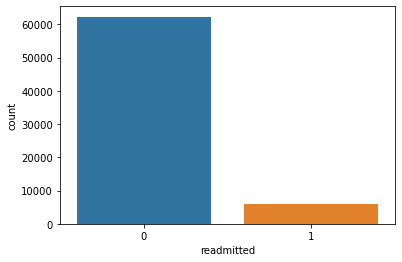

In [40]:
#Highlight imbalance

Include_30_df = Cleaned_df.copy()
Include_30_df['readmitted'] = Include_30_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

plt.figure()
sns.countplot(x='readmitted', data = Include_30_df)
plt.show()

# Random Undersampling

In [41]:
X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

undersample = RandomUnderSampler()
steps = [("u",undersample)]
pipeline = Pipeline(steps=steps)
X,y1=pipeline.fit_resample(x,y)

X_train_us, X_test_us,y_train_us,y_test_us = train_test_split(X,y1,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_us,y_train_us)
predict_log = logmodel.predict(X_test_us)
auc_log = roc_auc_score(y_test_us, predict_log)
print(classification_report(y_test_us,predict_log))
print(confusion_matrix(y_test_us,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_us,y_train_us)
predict_knn = clf.predict(X_test_us)
auc_knn = roc_auc_score(y_test_us, predict_knn)
print(classification_report(y_test_us,predict_knn))
print(confusion_matrix(y_test_us,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_us, y_train_us)
predict_tree = tree_model.predict(X_test_us)
auc_DT = roc_auc_score(y_test_us, predict_tree)
print(classification_report(y_test_us,predict_tree))
print(confusion_matrix(y_test_us,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_us,y_train_us)
predict_rf = rf.predict(X_test_us)
auc_rf = roc_auc_score(y_test_us, predict_rf)
print(classification_report(y_test_us,predict_rf))
print(confusion_matrix(y_test_us,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_us.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_us.columns.values]
#y_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in y_train.columns.values]



xgb=XGBClassifier()
xgb.fit(X_train_us, y_train_us)
predict_xgb = xgb.predict(X_test_us)
auc_xgb = roc_auc_score(y_test_us, predict_xgb)
print(classification_report(y_test_us,predict_xgb))
print(confusion_matrix(y_test_us,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.59      0.64      0.62      1541
           1       0.60      0.55      0.57      1504

    accuracy                           0.60      3045
   macro avg       0.60      0.60      0.60      3045
weighted avg       0.60      0.60      0.60      3045

[[987 554]
 [674 830]]
KNN
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      1541
           1       0.53      0.51      0.52      1504

    accuracy                           0.53      3045
   macro avg       0.53      0.53      0.53      3045
weighted avg       0.53      0.53      0.53      3045

[[862 679]
 [738 766]]
Decision Trees
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1541
           1       0.56      0.57      0.56      1504

    accuracy                           0.56      3045
   macro avg       0.56      0.56      0.56

In [42]:
print('Cleaned model for 30day readmission Keeping >30 with Random US ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_us, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_us, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_us, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_us, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_us, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_us, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_us, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_us, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_us, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_us, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_us, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_us, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_us, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_us, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_us, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_us, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_us, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_us, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_us, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_us, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Keeping >30 with Random US 
--------------------------------------------------------
Accuracy score of the DT model: 0.5628899835796387
Precision score of the DT model: 0.5559146735617324
Recall score of the DT model: 0.5718085106382979
F1 score of the DT model: 0.5637495902982628
AUC score of the DT model: 0.56
--------------------------------------------------------
Accuracy score of the KNN model: 0.5346469622331691
Precision score of the KNN model: 0.5301038062283737
Recall score of the KNN model: 0.5093085106382979
F1 score of the KNN model: 0.5194981349610037
AUC score of the KNN model: 0.53
--------------------------------------------------------
Accuracy score of the LR model: 0.5967159277504105
Precision score of the LR model: 0.5997109826589595
Recall score of the LR model: 0.5518617021276596
F1 score of the LR model: 0.574792243767313
AUC score of the LR model: 0.60
--------------------------------------------------------
-----------------

# Random Oversampling

In [43]:
X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X,y1=ros.fit_resample(x,y)
X_train_os, X_test_os,y_train_os,y_test_os = train_test_split(X,y1,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_os,y_train_os)
predict_log = logmodel.predict(X_test_os)
auc_log = roc_auc_score(y_test_os, predict_log)
print(classification_report(y_test_os,predict_log))
print(confusion_matrix(y_test_os,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_os,y_train_os)
predict_knn = clf.predict(X_test_os)
auc_knn = roc_auc_score(y_test_os, predict_knn)
print(classification_report(y_test_os,predict_knn))
print(confusion_matrix(y_test_os,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_os, y_train_os)
predict_tree = tree_model.predict(X_test_os)
auc_DT = roc_auc_score(y_test_os, predict_tree)
print(classification_report(y_test_os,predict_tree))
print(confusion_matrix(y_test_os,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_os,y_train_os)
predict_rf = rf.predict(X_test_os)
auc_rf = roc_auc_score(y_test_os, predict_rf)
print(classification_report(y_test_os,predict_rf))
print(confusion_matrix(y_test_os,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_os.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_os.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_os, y_train_os)
predict_xgb = xgb.predict(X_test_os)
auc_xgb = roc_auc_score(y_test_os, predict_xgb)
print(classification_report(y_test_os,predict_xgb))
print(confusion_matrix(y_test_os,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.62      0.67      0.64     15658
           1       0.63      0.58      0.61     15476

    accuracy                           0.62     31134
   macro avg       0.63      0.62      0.62     31134
weighted avg       0.63      0.62      0.62     31134

[[10471  5187]
 [ 6495  8981]]
KNN
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     15658
           1       0.78      0.99      0.87     15476

    accuracy                           0.86     31134
   macro avg       0.88      0.86      0.85     31134
weighted avg       0.88      0.86      0.85     31134

[[11279  4379]
 [  117 15359]]
Decision Trees
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     15658
           1       0.87      1.00      0.93     15476

    accuracy                           0.93     31134
   macro avg       0.94    

In [44]:
print('Cleaned model for 30day readmission Keeping >30 with Random OS ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_os, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_os, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_os, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_os, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_os, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_os, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_os, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_os, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_os, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_os, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_os, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_os, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_os, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_os, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_os, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_os, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_os, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_os, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_os, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_os, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Keeping >30 with Random OS 
--------------------------------------------------------
Accuracy score of the DT model: 0.928342005524507
Precision score of the DT model: 0.8743005708472277
Recall score of the DT model: 0.9995476867407599
F1 score of the DT model: 0.9327384003135457
AUC score of the DT model: 0.93
--------------------------------------------------------
Accuracy score of the KNN model: 0.8555919573456671
Precision score of the KNN model: 0.7781436822373088
Recall score of the KNN model: 0.9924399069527009
F1 score of the KNN model: 0.8723235076958028
AUC score of the KNN model: 0.86
--------------------------------------------------------
Accuracy score of the LR model: 0.6247831952206591
Precision score of the LR model: 0.633893280632411
Recall score of the LR model: 0.580317911605066
F1 score of the LR model: 0.6059236270408852
AUC score of the LR model: 0.62
--------------------------------------------------------
-------------------

# SMOTE

In [45]:
X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_sm,y_train_sm)
predict_log = logmodel.predict(X_test_sm)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_sm,y_train_sm)
predict_knn = clf.predict(X_test_sm)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_sm, y_train_sm)
predict_tree = tree_model.predict(X_test_sm)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_sm,y_train_sm)
predict_rf = rf.predict(X_test_sm)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_sm.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_sm.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
predict_xgb = xgb.predict(X_test_sm)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     15658
           1       0.99      0.89      0.94     15476

    accuracy                           0.94     31134
   macro avg       0.95      0.94      0.94     31134
weighted avg       0.95      0.94      0.94     31134

[[15575    83]
 [ 1664 13812]]
KNN
              precision    recall  f1-score   support

           0       1.00      0.29      0.45     15658
           1       0.58      1.00      0.73     15476

    accuracy                           0.64     31134
   macro avg       0.79      0.64      0.59     31134
weighted avg       0.79      0.64      0.59     31134

[[ 4496 11162]
 [    6 15470]]
Decision Trees
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     15658
           1       0.92      0.91      0.91     15476

    accuracy                           0.91     31134
   macro avg       0.91    

In [46]:
print('Cleaned model for 30day readmission including >30 with SMOTE ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission including >30 with SMOTE 
--------------------------------------------------------
Accuracy score of the DT model: 0.9143059035138433
Precision score of the DT model: 0.915412558380903
Recall score of the DT model: 0.9118635306280692
F1 score of the DT model: 0.9136345979541629
AUC score of the DT model: 0.91
--------------------------------------------------------
Accuracy score of the KNN model: 0.6412924776771375
Precision score of the KNN model: 0.5808801441874437
Recall score of the KNN model: 0.9996123029206513
F1 score of the KNN model: 0.7347772394794339
AUC score of the KNN model: 0.64
--------------------------------------------------------
Accuracy score of the LR model: 0.9438877111839147
Precision score of the LR model: 0.9940266282835553
Recall score of the LR model: 0.8924786766606359
F1 score of the LR model: 0.940519560110313
AUC score of the LR model: 0.94
--------------------------------------------------------
--------------------

# Effect of SMOTE on exclusion of >30 data

In [47]:
Excluding_30 = Cleaned_df.copy()

Excluding_30_df = Excluding_30.loc[(Excluding_30['readmitted'] != '>30')]

Excluding_30_df['readmitted'] = Excluding_30_df['readmitted'].map({'NO':0,'<30':1})

X_encoded = pd.get_dummies(Excluding_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_sm,y_train_sm)
predict_log = logmodel.predict(X_test_sm)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_sm,y_train_sm)
predict_knn = clf.predict(X_test_sm)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_sm, y_train_sm)
predict_tree = tree_model.predict(X_test_sm)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_sm,y_train_sm)
predict_rf = rf.predict(X_test_sm)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_sm.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_sm.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
predict_xgb = xgb.predict(X_test_sm)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     10152
           1       0.98      0.85      0.91     10213

    accuracy                           0.92     20365
   macro avg       0.93      0.92      0.92     20365
weighted avg       0.93      0.92      0.92     20365

[[10018   134]
 [ 1511  8702]]
KNN
              precision    recall  f1-score   support

           0       0.99      0.29      0.45     10152
           1       0.58      1.00      0.74     10213

    accuracy                           0.64     20365
   macro avg       0.79      0.64      0.59     20365
weighted avg       0.79      0.64      0.59     20365

[[ 2919  7233]
 [   31 10182]]
Decision Trees
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     10152
           1       0.88      0.88      0.88     10213

    accuracy                           0.88     20365
   macro avg       0.88    

In [48]:
print('Cleaned model for 30day readmission Excluding >30 with SMOTE ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Excluding >30 with SMOTE 
--------------------------------------------------------
Accuracy score of the DT model: 0.8803339062116377
Precision score of the DT model: 0.8834319526627219
Recall score of the DT model: 0.8771173993929305
F1 score of the DT model: 0.8802633518400236
AUC score of the DT model: 0.88
--------------------------------------------------------
Accuracy score of the KNN model: 0.6433095998035846
Precision score of the KNN model: 0.5846683893195521
Recall score of the KNN model: 0.9969646528933712
F1 score of the KNN model: 0.7370783263356014
AUC score of the KNN model: 0.64
--------------------------------------------------------
Accuracy score of the LR model: 0.919224159096489
Precision score of the LR model: 0.9848347668628339
Recall score of the LR model: 0.8520513071575443
F1 score of the LR model: 0.91364376082734
AUC score of the LR model: 0.92
--------------------------------------------------------
---------------------

# Observe Effects of Standardisation

In [ ]:
Include_30_df = Cleaned_df.copy()
Include_30_df['readmitted'] = Include_30_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

X_train_scaled = scale(X_train_sm)
X_test_scaled = scale(X_test_sm)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_scaled,y_train_sm)
predict_log = logmodel.predict(X_test_scaled)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_scaled,y_train_sm)
predict_knn = clf.predict(X_test_scaled)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_scaled, y_train_sm)
predict_tree = tree_model.predict(X_test_scaled)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train_sm)
predict_rf = rf.predict(X_test_scaled)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
#X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_scaled, y_train_sm)
predict_xgb = xgb.predict(X_test_scaled)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     15658
           1       0.98      0.90      0.94     15476

    accuracy                           0.94     31134
   macro avg       0.95      0.94      0.94     31134
weighted avg       0.95      0.94      0.94     31134

[[15438   220]
 [ 1527 13949]]
KNN


In [10]:
print('Cleaned model for 30day readmission Including >30 with SMOTE and scale ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Including >30 with SMOTE and scale 
--------------------------------------------------------
Accuracy score of the DT model: 0.909873450247318
Precision score of the DT model: 0.9089735313105229
Recall score of the DT model: 0.909795812871543
F1 score of the DT model: 0.9093844862106826
AUC score of the DT model: 0.91
--------------------------------------------------------
Accuracy score of the KNN model: 0.9418641999100662
Precision score of the KNN model: 0.9803852643419573
Recall score of the KNN model: 0.901072628586198
F1 score of the KNN model: 0.9390572390572391
AUC score of the KNN model: 0.94
--------------------------------------------------------
Accuracy score of the LR model: 0.9443694995824501
Precision score of the LR model: 0.9859284401074813
Recall score of the LR model: 0.9009433962264151
F1 score of the LR model: 0.9415220474036059
AUC score of the LR model: 0.94
--------------------------------------------------------
-----------

# Feature Selection 

- Filtering 
- Extraction : PCA vs LDA

In [5]:
Include_30_df = Cleaned_df.copy()
Include_30_df['readmitted'] = Include_30_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})
Filtered_df = Include_30_df.drop(['metformin','repaglinide', 'nateglinide','chlorpropamide','glimepiride','acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone','acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'diag_2', 'diag_3'],axis = 1)

X_encoded = pd.get_dummies(Filtered_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id',
                                                     'admission_source_id','diag_1','max_glu_serum','A1Cresult','insulin',
                                                     'change', 'diabetesMed'])

X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

X_train_scaled = scale(X_train_sm)
X_test_scaled = scale(X_test_sm)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_sm,y_train_sm)
predict_log = logmodel.predict(X_test_sm)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_sm,y_train_sm)
predict_knn = clf.predict(X_test_sm)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_sm, y_train_sm)
predict_tree = tree_model.predict(X_test_sm)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_sm,y_train_sm)
predict_rf = rf.predict(X_test_sm)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_sm.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_sm.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
predict_xgb = xgb.predict(X_test_sm)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     15658
           1       0.97      0.88      0.93     15476

    accuracy                           0.93     31134
   macro avg       0.93      0.93      0.93     31134
weighted avg       0.93      0.93      0.93     31134

[[15291   367]
 [ 1814 13662]]
KNN
              precision    recall  f1-score   support

           0       1.00      0.48      0.65     15658
           1       0.66      1.00      0.79     15476

    accuracy                           0.74     31134
   macro avg       0.83      0.74      0.72     31134
weighted avg       0.83      0.74      0.72     31134

[[ 7519  8139]
 [   11 15465]]
Decision Trees
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     15658
           1       0.91      0.91      0.91     15476

    accuracy                           0.91     31134
   macro avg       0.91    

In [7]:
print('Cleaned model for 30day readmission Including >30 with SMOTE, scaling, Filtering ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Including >30 with SMOTE, scaling, Filtering 
--------------------------------------------------------
Accuracy score of the DT model: 0.9126357037322541
Precision score of the DT model: 0.9119622787753521
Recall score of the DT model: 0.9123158438873094
F1 score of the DT model: 0.9121390270689321
AUC score of the DT model: 0.91
--------------------------------------------------------
Accuracy score of the KNN model: 0.7382283034624526
Precision score of the KNN model: 0.6551855617691916
Recall score of the KNN model: 0.9992892220211941
F1 score of the KNN model: 0.7914534288638689
AUC score of the KNN model: 0.74
--------------------------------------------------------
Accuracy score of the LR model: 0.9299479668529582
Precision score of the LR model: 0.9738399030579514
Recall score of the LR model: 0.8827862496769191
F1 score of the LR model: 0.9260803253685816
AUC score of the LR model: 0.93
-------------------------------------------------------

# PCA

In [6]:
X_encoded = pd.get_dummies(include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

X_train_scaled = scale(X_train_sm)
X_test_scaled = scale(X_test_sm)

from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)
pca.fit(X_train_scaled)

X_train_scaled_pca=pca.transform(X_train_scaled)
X_test_scaled_pca=pca.transform(X_test_scaled)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_scaled_pca,y_train_sm)
predict_log = logmodel.predict(X_test_scaled_pca)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_scaled_pca,y_train_sm)
predict_knn = clf.predict(X_test_scaled_pca)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_scaled_pca, y_train_sm)
predict_tree = tree_model.predict(X_test_scaled_pca)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_scaled_pca,y_train_sm)
predict_rf = rf.predict(X_test_scaled_pca)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
#X_train_scaled_pca.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_scaled_pca.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_scaled_pca, y_train_sm)
predict_xgb = xgb.predict(X_test_scaled_pca)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     15658
           1       0.71      0.73      0.72     15476

    accuracy                           0.72     31134
   macro avg       0.72      0.72      0.72     31134
weighted avg       0.72      0.72      0.72     31134

[[11111  4547]
 [ 4155 11321]]
KNN
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     15658
           1       0.73      0.99      0.84     15476

    accuracy                           0.81     31134
   macro avg       0.86      0.81      0.81     31134
weighted avg       0.86      0.81      0.81     31134

[[ 9900  5758]
 [   95 15381]]
Decision Trees
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     15658
           1       0.83      0.88      0.85     15476

    accuracy                           0.85     31134
   macro avg       0.85    

In [7]:
print('Cleaned model for 30day readmission Including >30 with SMOTE and scale and PCA ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Including >30 with SMOTE and scale and PCA 
--------------------------------------------------------
Accuracy score of the DT model: 0.8500032119226569
Precision score of the DT model: 0.8302163549688302
Recall score of the DT model: 0.8777461876453864
F1 score of the DT model: 0.8533199321565424
AUC score of the DT model: 0.85
--------------------------------------------------------
Accuracy score of the KNN model: 0.8120061668915013
Precision score of the KNN model: 0.7276124698424713
Recall score of the KNN model: 0.9938614629103127
F1 score of the KNN model: 0.840147480540762
AUC score of the KNN model: 0.81
--------------------------------------------------------
Accuracy score of the LR model: 0.7204984903963513
Precision score of the LR model: 0.7134484497101083
Recall score of the LR model: 0.7315197725510468
F1 score of the LR model: 0.7223711077080143
AUC score of the LR model: 0.72
--------------------------------------------------------
-

# LDA

In [8]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(x, y)

# Create array of explained variance ratios
lda_var_ratios = lda.explained_variance_ratio_


# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components


# Run function
select_n_components(lda_var_ratios, 0.99)

1

In [9]:
X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

# X_train_scaled_sm = scale(X_train_sm)
# X_test_scaled_sm = scale(X_test_sm)

X_train_lda=lda.fit_transform(X_train_sm,y_train_sm)

X_test_lda=lda.transform(X_test_sm)

print('Logistic Regression')
logmodel = LogisticRegression()
logmodel.fit(X_train_lda,y_train_sm)
predict_log = logmodel.predict(X_test_lda)
auc_log = roc_auc_score(y_test_sm, predict_log)
print(classification_report(y_test_sm,predict_log))
print(confusion_matrix(y_test_sm,predict_log))

print('KNN')
clf = KNeighborsClassifier()
clf.fit(X_train_lda,y_train_sm)
predict_knn = clf.predict(X_test_lda)
auc_knn = roc_auc_score(y_test_sm, predict_knn)
print(classification_report(y_test_sm,predict_knn))
print(confusion_matrix(y_test_sm,predict_knn))

print('Decision Trees')
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_lda, y_train_sm)
predict_tree = tree_model.predict(X_test_lda)
auc_DT = roc_auc_score(y_test_sm, predict_tree)
print(classification_report(y_test_sm,predict_tree))
print(confusion_matrix(y_test_sm,predict_tree))

print('Random Forest')
rf = RandomForestClassifier()
rf.fit(X_train_lda,y_train_sm)
predict_rf = rf.predict(X_test_lda)
auc_rf = roc_auc_score(y_test_sm, predict_rf)
print(classification_report(y_test_sm,predict_rf))
print(confusion_matrix(y_test_sm,predict_rf))

print('XGBOOST')
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
#X_train_lda.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_lda.columns.values]

xgb=XGBClassifier()
xgb.fit(X_train_lda, y_train_sm)
predict_xgb = xgb.predict(X_test_lda)
auc_xgb = roc_auc_score(y_test_sm, predict_xgb)
print(classification_report(y_test_sm,predict_xgb))
print(confusion_matrix(y_test_sm,predict_xgb))

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     15658
           1       0.99      0.90      0.94     15476

    accuracy                           0.94     31134
   macro avg       0.95      0.94      0.94     31134
weighted avg       0.95      0.94      0.94     31134

[[15459   199]
 [ 1533 13943]]
KNN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     15658
           1       0.98      0.90      0.94     15476

    accuracy                           0.94     31134
   macro avg       0.94      0.94      0.94     31134
weighted avg       0.94      0.94      0.94     31134

[[15379   279]
 [ 1531 13945]]
Decision Trees
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     15658
           1       0.91      0.91      0.91     15476

    accuracy                           0.91     31134
   macro avg       0.91    

In [11]:
print('Cleaned model for 30day readmission Including >30 with SMOTE and scale and LDA ')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree)))
print('AUC score of the DT model: %.2f' % auc_DT)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn)))
print('AUC score of the KNN model: %.2f' % auc_knn)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log)))
print('AUC score of the LR model: %.2f' % auc_log)
print('--------------------------------------------------------')
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf)))
print('AUC score of the RF model: %.2f' % auc_rf)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb)))
print('AUC score of the XGB model: %.2f' % auc_xgb)

Cleaned model for 30day readmission Including >30 with SMOTE and scale and LDA 
--------------------------------------------------------
Accuracy score of the DT model: 0.909873450247318
Precision score of the DT model: 0.9089735313105229
Recall score of the DT model: 0.909795812871543
F1 score of the DT model: 0.9093844862106826
AUC score of the DT model: 0.91
--------------------------------------------------------
Accuracy score of the KNN model: 0.9418641999100662
Precision score of the KNN model: 0.9803852643419573
Recall score of the KNN model: 0.901072628586198
F1 score of the KNN model: 0.9390572390572391
AUC score of the KNN model: 0.94
--------------------------------------------------------
Accuracy score of the LR model: 0.9443694995824501
Precision score of the LR model: 0.9859284401074813
Recall score of the LR model: 0.9009433962264151
F1 score of the LR model: 0.9415220474036059
AUC score of the LR model: 0.94
--------------------------------------------------------
---

# Hyperparameter tuning via RandomSearchCV

In [5]:
Include_30_df = Cleaned_df.copy()
Include_30_df['readmitted'] = Include_30_df['readmitted'].map({'NO':0, '>30': 0, '<30':1})

X_encoded = pd.get_dummies(Include_30_df, columns = ['race','gender','age','admission_type_id', 'discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3', 'max_glu_serum',
                                          'A1Cresult', 'metformin','repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone',
                                          'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin',
                                          'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                          'metformin-pioglitazone', 'change', 'diabetesMed'])
X_encoded

x = X_encoded.drop('readmitted',axis=1).copy()
y = X_encoded['readmitted'].copy()


from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(x, y)

# Create array of explained variance ratios
lda_var_ratios = lda.explained_variance_ratio_


# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components


# Run function
select_n_components(lda_var_ratios, 0.99)



sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(x,y)
X_train_sm, X_test_sm,y_train_sm,y_test_sm = train_test_split(X_sm,y_sm,random_state=42)

# X_train_scaled_sm = scale(X_train_sm)
# X_test_scaled_sm = scale(X_test_sm)

X_train_lda=lda.fit_transform(X_train_sm,y_train_sm)

X_test_lda=lda.transform(X_test_sm)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4],'max_depth': [15,25,35]}
random_search_cv = RandomizedSearchCV(DecisionTreeClassifier(), params,  n_iter=2, verbose=2, cv=3, random_state=42)
random_search_cv.fit(X_train_lda, y_train_sm)
print("DT - Best Score :  ",random_search_cv.best_score_)
print(random_search_cv.best_params_)
print("DT - Best Parameters : ",random_search_cv.best_estimator_)
# default options - uniform (all points in the neighborhood are weighted equally)
# another option - distance (weights closer neighbors more heavily than further neighbors)
# n_neighbors is K
param_dist = dict(n_neighbors=range(1, 31), weights=['uniform', 'distance'])
random_search_cv = RandomizedSearchCV(KNeighborsClassifier(),param_distributions=param_dist, n_iter=2, verbose=2, cv=3, random_state=42)
random_search_cv.fit(X_train_lda, y_train_sm)
print("KNN - Best Score :  ",random_search_cv.best_score_)
print(random_search_cv.best_params_)
print("KNN - Best Parameters : ",random_search_cv.best_estimator_)
                                                                   
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)
# Create hyperparameter options (Albon, 2017)
hyperparameters = dict(C=C, penalty=penalty)
random_search_cv = RandomizedSearchCV(LogisticRegression(), hyperparameters, n_iter=2, verbose=2, cv=3, random_state=42)
random_search_cv.fit(X_train_lda, y_train_sm)
print("LR - Best Score :  ",random_search_cv.best_score_)
print(random_search_cv.best_params_)
print("LR - Best Parameters : ",random_search_cv.best_estimator_)                                                                     
                                                                     
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4],'max_depth': [15,25,35]}
random_search_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, n_iter=2, verbose=2, cv=3, random_state=42)
random_search_cv.fit(X_train_lda, y_train_sm)
print("RF - Best Score :  ",random_search_cv.best_score_)
print(random_search_cv.best_params_)
print("RF - Best Parameters : ",random_search_cv.best_estimator_)

params = {'max_depth': [15,25,35]}
random_search_cv = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=2)
random_search_cv.fit(X_train_lda, y_train_sm)
print("XGB - Best Score : ",random_search_cv.best_score_)
print(random_search_cv.best_params_)
print("XGB - Best Parameters : ",random_search_cv.best_estimator_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............
[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   0.1s
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............
[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   0.1s
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............
[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   0.0s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   0.0s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............
[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   0.1s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............
[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   0.1s
DT - Best Score :   0.9513714909744974
{'min_samples_split': 2, 'max_leaf_nodes': 49, 'max_depth': 25}
DT - Best Parameters :  DecisionTreeClassifier(max_depth=25, max_leaf_nodes=49)
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] weights=uniform, n_neighbors=1 ..................................
[CV] ................... weights=uniform, n_neighbors=1, total=   0.9s
[CV] weights=uniform, n_neighbors=1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ................... weights=uniform, n_neighbors=1, total=   0.9s
[CV] weights=uniform, n_neighbors=1 ..................................
[CV] ................... weights=uniform, n_neighbors=1, total=   0.8s
[CV] weights=distance, n_neighbors=3 .................................
[CV] .................. weights=distance, n_neighbors=3, total=   0.1s
[CV] weights=distance, n_neighbors=3 .................................
[CV] .................. weights=distance, n_neighbors=3, total=   0.1s
[CV] weights=distance, n_neighbors=3 .................................
[CV] .................. weights=distance, n_neighbors=3, total=   0.1s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


KNN - Best Score :   0.926682512151774
{'weights': 'distance', 'n_neighbors': 3}
KNN - Best Parameters :  KNeighborsClassifier(n_neighbors=3, weights='distance')
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] C=1.49816047538945, penalty=l1 ..................................
[CV] ................... C=1.49816047538945, penalty=l1, total=   0.0s
[CV] C=1.49816047538945, penalty=l1 ..................................
[CV] ................... C=1.49816047538945, penalty=l1, total=   0.0s
[CV] C=1.49816047538945, penalty=l1 ..................................
[CV] ................... C=1.49816047538945, penalty=l1, total=   0.0s
[CV] C=0.7337391594646552, penalty=l2 ................................
[CV] ................. C=0.7337391594646552, penalty=l2, total=   0.1s
[CV] C=0.7337391594646552, penalty=l2 ................................
[CV] ................. C=0.7337391594646552, penalty=l2, total=   0.1s
[CV] C=0.7337391594646552, penalty=l2 ...............................

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LR - Best Score :   0.951735508875613
{'C': 0.7337391594646552, 'penalty': 'l2'}
LR - Best Parameters :  LogisticRegression(C=0.7337391594646552)
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............
[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   3.0s
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   3.0s
[CV] min_samples_split=2, max_leaf_nodes=36, max_depth=15 ............
[CV]  min_samples_split=2, max_leaf_nodes=36, max_depth=15, total=   2.9s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............
[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   3.0s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............
[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   3.0s
[CV] min_samples_split=2, max_leaf_nodes=49, max_depth=25 ............
[CV]  min_samples_split=2, max_leaf_nodes=49, max_depth=25, total=   3.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s finished


RF - Best Score :   0.9520459947324468
{'min_samples_split': 2, 'max_leaf_nodes': 36, 'max_depth': 15}
RF - Best Parameters :  RandomForestClassifier(max_depth=15, max_leaf_nodes=36)
[11:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd

In [6]:
tree_model = DecisionTreeClassifier(min_samples_split=2,max_leaf_nodes = 49,max_depth=25)
tree_model.fit(X_train_lda, y_train_sm)
predict_tree_cv = tree_model.predict(X_test_lda)
auc_DT_cv = roc_auc_score(y_test_sm, predict_tree_cv)


knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(X_train_lda, y_train_sm)
predict_knn_cv = knn.predict(X_test_lda)
auc_knn_cv = roc_auc_score(y_test_sm, predict_knn_cv)


logmodel = LogisticRegression(C=0.7337391594646552, penalty='l2')
logmodel.fit(X_train_lda, y_train_sm)
predict_log_cv = logmodel.predict(X_test_lda)
auc_log_cv = roc_auc_score(y_test_sm, predict_log_cv)


rf = RandomForestClassifier(min_samples_split=2,max_leaf_nodes= 49, max_depth=25)
rf.fit(X_train_lda,y_train_sm)
predict_rf_cv = rf.predict(X_test_lda)
auc_rf_cv = roc_auc_score(y_test_sm, predict_rf_cv)



xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=15, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb.fit(X_train_lda, y_train_sm)
predict_xgb_cv = xgb.predict(X_test_lda)
auc_xgb_cv = roc_auc_score(y_test_sm, predict_xgb_cv)

[12:37:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [8]:
print('Final models with tuned Hyperparameters')
print('--------------------------------------------------------')
print('Accuracy score of the DT model: {}'.format(accuracy_score(y_test_sm, predict_tree_cv)))
print('Precision score of the DT model: {}'.format(precision_score(y_test_sm, predict_tree_cv)))
print('Recall score of the DT model: {}'.format(recall_score(y_test_sm, predict_tree_cv)))
print('F1 score of the DT model: {}'.format(f1_score(y_test_sm, predict_tree_cv)))
print('AUC score of the DT model: %.2f' % auc_DT_cv)
print('--------------------------------------------------------')
print('Accuracy score of the KNN model: {}'.format(accuracy_score(y_test_sm, predict_knn_cv)))
print('Precision score of the KNN model: {}'.format(precision_score(y_test_sm, predict_knn_cv)))
print('Recall score of the KNN model: {}'.format(recall_score(y_test_sm, predict_knn_cv)))
print('F1 score of the KNN model: {}'.format(f1_score(y_test_sm, predict_knn_cv)))
print('AUC score of the KNN model: %.2f' % auc_knn_cv)
print('--------------------------------------------------------')
print('Accuracy score of the LR model: {}'.format(accuracy_score(y_test_sm, predict_log_cv)))
print('Precision score of the LR model: {}'.format(precision_score(y_test_sm, predict_log_cv)))
print('Recall score of the LR model: {}'.format(recall_score(y_test_sm, predict_log_cv)))
print('F1 score of the LR model: {}'.format(f1_score(y_test_sm, predict_log_cv)))
print('AUC score of the LR model: %.2f' % auc_log_cv)
print('--------------------------------------------------------')
print('Accuracy score of the RF model: {}'.format(accuracy_score(y_test_sm, predict_rf_cv)))
print('Precision score of the RF model: {}'.format(precision_score(y_test_sm, predict_rf_cv)))
print('Recall score of the RF model: {}'.format(recall_score(y_test_sm, predict_rf_cv)))
print('F1 score of the RF model: {}'.format(f1_score(y_test_sm, predict_rf_cv)))
print('AUC score of the RF model: %.2f' % auc_rf_cv)
print('--------------------------------------------------------')
print('Accuracy score of the XGB model: {}'.format(accuracy_score(y_test_sm, predict_xgb_cv)))
print('Precision score of the XGB model: {}'.format(precision_score(y_test_sm, predict_xgb_cv)))
print('Recall score of the XGB model: {}'.format(recall_score(y_test_sm, predict_xgb_cv)))
print('F1 score of the XGB model: {}'.format(f1_score(y_test_sm, predict_xgb_cv)))
print('AUC score of the XGB model: %.2f' % auc_xgb_cv)

Final models with tuned Hyperparameters
--------------------------------------------------------
Accuracy score of the DT model: 0.945590030192073
Precision score of the DT model: 0.990392826643894
Recall score of the DT model: 0.8992633755492375
F1 score of the DT model: 0.9426307233811975
AUC score of the DT model: 0.95
--------------------------------------------------------
Accuracy score of the KNN model: 0.9199910066165606
Precision score of the KNN model: 0.9298245614035088
Recall score of the KNN model: 0.9075342465753424
F1 score of the KNN model: 0.9185441941074524
AUC score of the KNN model: 0.92
--------------------------------------------------------
Accuracy score of the LR model: 0.9443694995824501
Precision score of the LR model: 0.9859284401074813
Recall score of the LR model: 0.9009433962264151
F1 score of the LR model: 0.9415220474036059
AUC score of the LR model: 0.94
--------------------------------------------------------
Accuracy score of the RF model: 0.94600758